<a href="https://colab.research.google.com/github/whiteevl/machine-learning/blob/main/image_classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle


In [2]:
from google.colab import files
#Upload Kaggle API Key
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aradeabayumurti","key":"cba20ef726a7e9553d97a4ef2cd43144"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

 98% 216M/219M [00:01<00:00, 204MB/s]
100% 219M/219M [00:01<00:00, 156MB/s]


In [5]:
import os, zipfile

In [6]:
zipPath = '../content/rice-image-dataset.zip'
zipFile = zipfile.ZipFile(zipPath, 'r')
zipFile.extractall('../content/RiceDataset/')
zipFile.close()

In [7]:
FILE_PATH = '../content/RiceDataset/Rice_Image_Dataset/'

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 64

In [10]:
import os

dataset_path = '../content/RiceDataset/Rice_Image_Dataset/'

def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

total_images = 0
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        class_count = count_images_in_folder(class_path)
        print(f"{class_folder}: {class_count} images")
        total_images += class_count

print(f"Total Images in Dataset: {total_images}")


Basmati: 15000 images
Ipsala: 15000 images
Jasmine: 15000 images
Karacadag: 15000 images
Arborio: 15000 images
Total Images in Dataset: 75000


In [17]:
import os
from PIL import Image

dataset_directory = '../content/RiceDataset/Rice_Image_Dataset/'
process_images_in_directory(dataset_directory)

def get_image_size(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height

def process_images_in_directory(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Sesuaikan ekstensi gambar
            image_path = os.path.join(directory_path, filename)
            width, height = get_image_size(image_path)
            print(f'Ukuran gambar {filename}: {width} x {height} piksel')




In [18]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

train_generator = train_datagen.flow_from_directory(
    FILE_PATH,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    FILE_PATH,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset='validation'
)

target_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization

In [20]:


model = Sequential([
    Conv2D(filters = 16, kernel_size = (5, 5), padding = 'Same', activation = 'relu', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.2),
    BatchNormalization(),

    Conv2D(filters = 32, kernel_size = (3, 3), padding = 'Same', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
    Dropout(0.2),

    Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])



In [21]:


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [22]:
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [24]:
class TargetCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95):
      print("\nAccuracy and Validation Accuracy has reached 95%!\nStop Train!")
      self.model.stop_training = True
Target = TargetCallback()

EarlyStop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.0001,
    patience = 5,
    verbose = 1,
    mode = 'auto'
)

In [25]:
History = model.fit(
    train_generator,
    epochs =  100,
    validation_data = val_generator,
    callbacks = [Target, EarlyStop],
    verbose = 1
)

Epoch 1/100
938/938 [==============================] - 2301s 2s/step - loss: 0.2192 - accuracy: 0.9265 - val_loss: 0.0902 - val_accuracy: 0.9682
Epoch 2/100
938/938 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.9614
Accuracy and Validation Accuracy has reached 95%!
Stop Train!
938/938 [==============================] - 2349s 3s/step - loss: 0.1165 - accuracy: 0.9614 - val_loss: 0.0861 - val_accuracy: 0.9699


In [27]:
import matplotlib.pyplot as plt

Loss with Val_Loss Graph


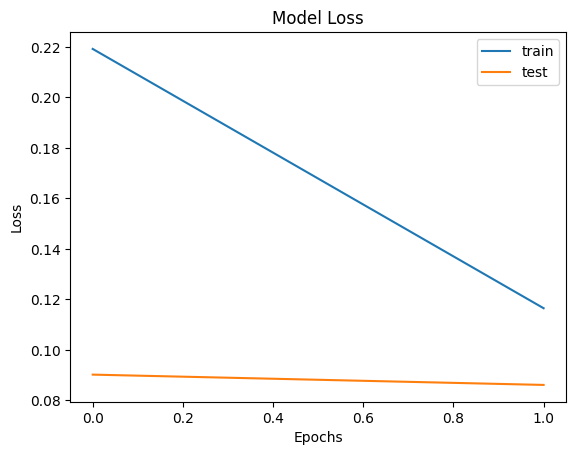

Acc with Val_Acc Graph


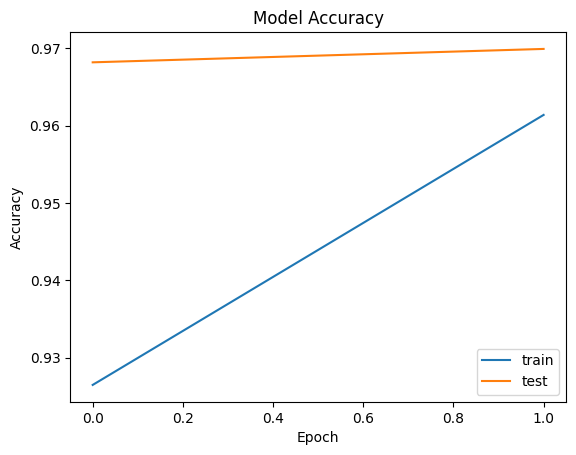

In [28]:


print("Loss with Val_Loss Graph")
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

print("Acc with Val_Acc Graph")
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



In [29]:
import tensorflow as tf
import pathlib

export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('RiceModel.tflite')
tflite_model_file.write_bytes(tflite_model)

5412200